# Clicks and pops detection

## Clicks and pops on audio
Click and pop sounds are some of the most frequent audio problems.
They can appear from electro-acoustic sources (damaged cables, hits on the microphone while singing, etc.) or digital ones (clocking issues, size of audio buffer, etc.) supposing some of the most disturbing types of audio degradation.
In this tutorial, we will learn how to detect clicks and pops with Essentia.

## Generating synthetic clicks
Let's start by creating and visualizing synthetic clicks with different amplitudes:

In [1]:
from IPython.display import Audio

from essentia.standard import MonoLoader, ClickDetector, FrameGenerator
from essentia import array
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] =(12,9)

Text(0.5, 1.0, 'Signal with synthetic clicks with different amplitudes')

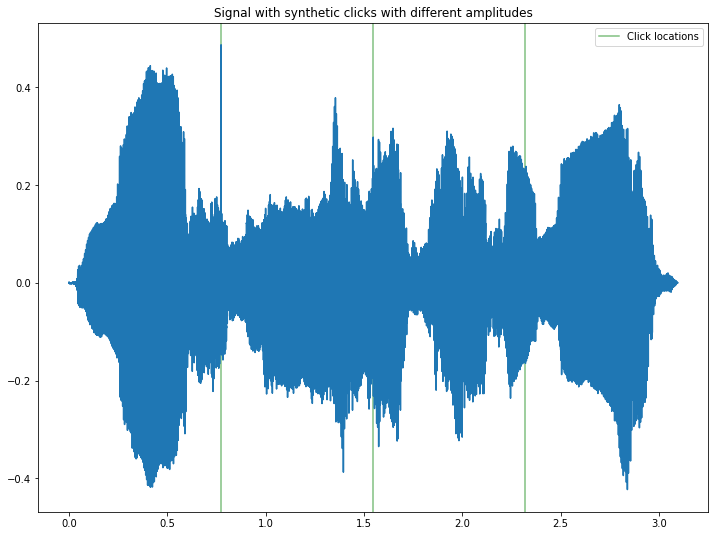

In [2]:
sr = 44100

audio_file = '../../../test/audio/recorded/vignesh.wav'
audio = MonoLoader(filename=audio_file)()

click_locs = [
    len(audio) // 4,
    len(audio) // 2,
    len(audio) * 3 // 4
]

# Create synthetic clicks with different amplitudes.
for click_loc, amp in zip(click_locs, [.5, .15, .05]):
    audio[click_loc] += amp

ground_truth = array(click_locs) / sr

for click_loc in ground_truth:
    l1 = plt.axvline(click_loc, color='g', alpha=.5)

time_axis = np.arange(len(audio)) / sr
plt.plot(time_axis, audio)

l1.set_label('Click locations')
plt.legend()
plt.title('Signal with synthetic clicks with different amplitudes')

Now we can listen to the degraded audio. Notice that the clicks are decreasing in amplitude, so each click is more difficult to perceive than the previous one.

In [3]:
Audio(audio, rate=sr)

## Detecting clicks
The [ClickDetector](https://essentia.upf.edu/reference/std_ClickDetector.html) algorithm implements Vaseghi's detection algorithm, which uses the prediction error from a frame-wise [LPC](https://en.wikipedia.org/wiki/Linear_predictive_coding) analysis to detect impulsive peaks [1].
The detection threshold is obtained from a robust estimate of the prediction error power [2] plus a gain parameter that can be adjusted by the user.

For each frame, the algorithm returns the starting and ending locations of the detected clicks and pops (which may coincide in the case of ideal one-sample clicks).
For convenience, the results are expressed in seconds from the beginning of the audio (not the frame).
Thus, the algorithm has to be `reset()` before processing a new audio stream (e.g., a new song).

In [4]:
# Analysis parameters.
frame_size = 512
hop_size = 256

clickDetector = ClickDetector(frameSize=frame_size, hopSize=hop_size)

starts, ends = [], []
for frame in FrameGenerator(
    audio, frameSize=frame_size, hopSize=hop_size, startFromZero=True
):
    frame_starts, frame_ends = clickDetector(frame)
    starts.extend(list(frame_starts))
    ends.extend(list(frame_ends))

Finally, we can plot the detections and the ground truth:

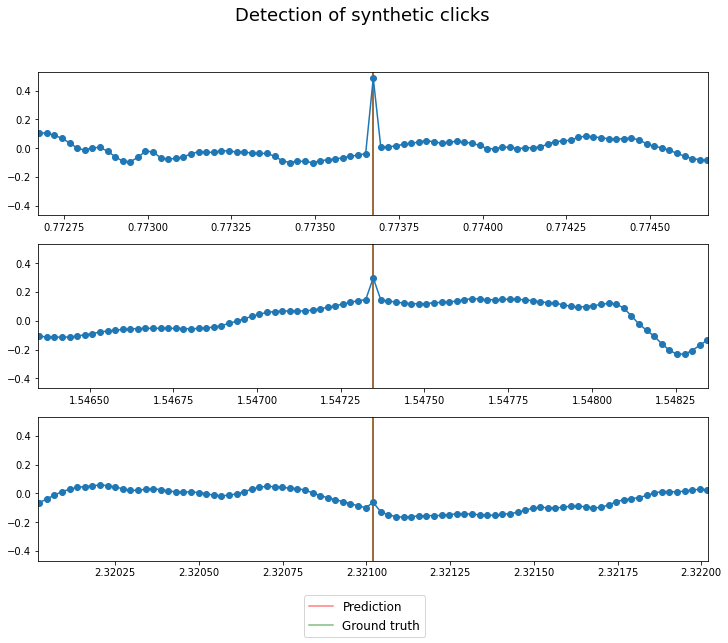

In [5]:
fig, ax = plt.subplots(len(ground_truth))

for idx, click_loc in enumerate(ground_truth):
    # Print the detection location.
    l1 = ax[idx].axvline(starts[idx], color='r', alpha=.5)
    ax[idx].axvline(ends[idx], color='r', alpha=.5)

    # Print the ground truth location.
    l2 = ax[idx].axvline(click_loc, color='g', alpha=.5)

    # Print the waveform.
    ax[idx].plot(time_axis, audio, marker='o')
    ax[idx].set_xlim([click_loc - .001, click_loc + .001])

fig.suptitle('Detection of synthetic clicks', fontsize=18)
fig.legend(
    (l1, l2), ("Prediction", "Ground truth"), fontsize=12, loc="lower center"
)

## References
[1] Vaseghi, S. V., & Rayner, P. J. W. (1990). Detection and suppression of
impulsive noise in speech communication systems. IEE Proceedings I
(Communications, Speech and Vision), 137(1), 38-46.

[2] Vaseghi, S. V. (2008). Advanced digital signal processing and noise
reduction. John Wiley & Sons. Page 355.